## Starting Simple. 

* Look at simulate_spec_files directory to see how below syntax has changed. 

In [1]:
%load_ext autoreload

In [7]:
%autoreload 2

# Imports.
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import seaborn as sns
import sys
import yaml
from time import process_time

# Additional settings. 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Path to local imports.
sys.path.append("/Users/winston/Desktop/6He-CRES/he6-cres-spec-sims/")

# Local imports.
# import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as blocks

## 0. Verifying that it works with just DAQ alone

In [8]:
class DotDict(dict):
    """Provides dot.notation access to dictionary attributes."""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


class Config:

    def __init__(self, config_path):

        self.config_path = pathlib.Path(config_path)
        self.load_config_file()

    def load_config_file(self):

        try:
            with open(self.config_path, "r") as read_file:
                config_dict = yaml.load(read_file, Loader=yaml.FullLoader)
                self.daq = DotDict(config_dict["Daq"])

        except Exception as e:
            print("Config file failed to load.")
            raise e
            

In [9]:
config_path = "demo/config/base_daq_config.yaml"
config = Config(config_path)

In [10]:
band_df = pd.DataFrame({"file_in_acq": np.array([0, 0, 0, 1, 1]),
                        "event_num": np.array([0, 1, 2, 0, 1]),
                        "time_start": np.array([.001, .002, .003, .004, .005]),
                        "time_stop": .004 + np.array([.001, .002, .003, .004, .005]),
                        "freq_start" : np.linspace(110e6, 700e6, 5),
                        "freq_stop" : np.linspace(110e6, 700e6, 5),
                        "slope" : np.array([1e10]*5),
                        "band_power_start": np.array([10e-15]*5),
                        "band_power_stop": np.array([10e-15]*5), 
                        "band_num": np.array([-1,0,1, -1, 1])
                       })
band_df.head()

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.001,0.005,110000000.0,110000000.0,1.000000e+10,1.000000e-14,1.000000e-14,-1
1,0,1,0.002,0.006,257500000.0,257500000.0,1.000000e+10,1.000000e-14,1.000000e-14,0
2,0,2,0.003,0.007,405000000.0,405000000.0,1.000000e+10,1.000000e-14,1.000000e-14,1
3,1,0,0.004,0.008,552500000.0,552500000.0,1.000000e+10,1.000000e-14,1.000000e-14,-1
4,1,1,0.005,0.009,700000000.0,700000000.0,1.000000e+10,1.000000e-14,1.000000e-14,1


In [11]:
## Starting with a simple (not physical) larger dataset to test the IO stuff. 

In [12]:
n_files = 5
band_df = pd.DataFrame({"file_in_acq": np.arange(n_files),
                        "event_num": np.array([0, 1, 2, 0, 1]*int(n_files/5)),
                        "time_start": np.array([.001, .002, .003, .004, .005]*int(n_files/5)),
                        "time_stop": .004 + np.array([.001, .002, .003, .004, .005]*int(n_files/5)),
                        "freq_start" : np.linspace(110e6, 700e6, n_files),
                        "freq_stop" : np.linspace(110e6, 700e6, n_files),
                        "slope" : np.array([1e10]*n_files),
                        "band_power_start": np.array([10e-15]*n_files),
                        "band_power_stop": np.array([10e-15]*n_files), 
                        "band_num": np.array([-1,0,1, -1, 1]*int(n_files/5))
                       })
band_df.head(10)

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.001,0.005,110000000.0,110000000.0,1.000000e+10,1.000000e-14,1.000000e-14,-1
1,1,1,0.002,0.006,257500000.0,257500000.0,1.000000e+10,1.000000e-14,1.000000e-14,0
2,2,2,0.003,0.007,405000000.0,405000000.0,1.000000e+10,1.000000e-14,1.000000e-14,1
3,3,0,0.004,0.008,552500000.0,552500000.0,1.000000e+10,1.000000e-14,1.000000e-14,-1
4,4,1,0.005,0.009,700000000.0,700000000.0,1.000000e+10,1.000000e-14,1.000000e-14,1


### Stuff we did on 1/23/23: 

* Use the following along with the build_simple_ds.py file to make a dataset. 
* Also use this df to get EVENT bounding boxes written to disk (json).
* Then follow the faster rcnn tutorial to get the dataset and dataloader working. 

In [33]:
def simple_fasterrcnn_ds(n_files, n_events_per_file, spec_length=.035, freq_bw=1200e8, seed = 1234):
    '''
    Define the DataFrame describing the simulation of various events over several spec files. Entries are track(?)-level description of
    the electron's motion in the CRES apparatus. 
    '''
    track_set = {
            "file_in_acq": [],
            "event_num": [],
            "time_start": [],
            "time_stop": [],
            "freq_start": [],
            "freq_stop": [],
            "slope": [],
            "band_power_start": [],
            "band_power_stop": [],
            "band_num": [],
        }
    
    # Define Generator object for pulling from distributions
    rng = np.random.default_rng(seed)
    
    # n_events in a spec file can be reasonably estimated from a Poisson distribution
    n_events = rng.poisson(lam=3, size=n_files) 
    
    # Loop over files
    for file, events in enumerate(n_events): 
        # Pull from uniform distribution to determine start time of event
        event_start_times = rng.uniform(low=0, high=spec_length, size=events)
        
#-------------------------------------------------------------------------------------------------------------------------
        # Get start frequencies
        # TODO: implement physical model of beta energies (not in this work)
        event_start_frequencies = rng.uniform(low=150e8, high=freq_bw, size=events)
#-------------------------------------------------------------------------------------------------------------------------

        # Loop over each event in file
        for event, (start_time, start_freq) in enumerate(zip(event_start_times, event_start_frequencies)):
            
#-------------------------------------------------------------------------------------------------------------------------
            # Define number of scatters per event
            # TODO: Implement a physical model for scattering
            n_tracks = rng.integers(low=3, high = 10)
#-------------------------------------------------------------------------------------------------------------------------

            # Loop over each track in event
            for track in range(n_tracks): 
                # Pull track length from exponential distribution with tau=10ms
                track_len = rng.exponential(scale=.01)
    
                # Slope of track is normally distributed around the mean of 2e8 in Kr83 events
                slope = rng.normal(loc=2e8, scale=1e7)
               
                # Store parameters in dict
                track_set["file_in_acq"].append(file)
                track_set["event_num"].append(event)
                track_set["time_start"].append(start_time)
                track_set["time_stop"].append(start_time+track_len)
                track_set["freq_start"].append(start_freq)
                track_set["slope"].append(slope)
                track_set["freq_stop"].append(start_freq+slope*track_len)
    
 #-------------------------------------------------------------------------------------------------------------------------   
    # TODO: implement proper power information
    track_set["band_power_start"] = [1e-14]*len(track_set["slope"])
    track_set["band_power_stop"] = [1e-14]*len(track_set["slope"])
    track_set["band_num"] = np.zeros(len(track_set["slope"]))
#-------------------------------------------------------------------------------------------------------------------------
    
    return pd.DataFrame(track_set)

In [34]:
simple_fasterrcnn_ds(10, 3)

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.012968,0.018473,7.133945e+10,7.134065e+10,2.166542e+08,1.000000e-14,1.000000e-14,0.0
1,0,0,0.012968,0.017898,7.133945e+10,7.134038e+10,1.879740e+08,1.000000e-14,1.000000e-14,0.0
2,0,0,0.012968,0.043496,7.133945e+10,7.134525e+10,1.897880e+08,1.000000e-14,1.000000e-14,0.0
3,0,0,0.012968,0.033675,7.133945e+10,7.134370e+10,2.049808e+08,1.000000e-14,1.000000e-14,0.0
4,0,0,0.012968,0.024856,7.133945e+10,7.134186e+10,2.020249e+08,1.000000e-14,1.000000e-14,0.0
5,0,0,0.012968,0.020599,7.133945e+10,7.134105e+10,2.083706e+08,1.000000e-14,1.000000e-14,0.0
6,0,0,0.012968,0.015571,7.133945e+10,7.133994e+10,1.882585e+08,1.000000e-14,1.000000e-14,0.0
7,0,1,0.016893,0.019391,9.198932e+10,9.198987e+10,2.173739e+08,1.000000e-14,1.000000e-14,0.0
8,0,1,0.016893,0.016992,9.198932e+10,9.198934e+10,2.170332e+08,1.000000e-14,1.000000e-14,0.0
9,0,1,0.016893,0.028606,9.198932e+10,9.199185e+10,2.155724e+08,1.000000e-14,1.000000e-14,0.0


In [9]:
daq = blocks.DAQ(config)

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [13]:
config.__dict__

{'config_path': PosixPath('/media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0.yaml'),
 'daq': {'spec_length': 0.01,
  'freq_bw': 1200000000.0,
  'freq_bins': 4096,
  'roach_avg': 2,
  'requant_gain': 20,
  'base_gain': 500000000000.0,
  'rng_seed': 123456,
  'build_labels': True,
  'waveguide_side"': 'I',
  'gain_noise_cvs_path': '/home/drew/He6CRES/cres_deep_learning/gain_noise/gain_noise_2^12_08042022.csv',
  'spec_prefix': 'test'}}

### Run the DAQ block. 

In [14]:
%matplotlib inline
daq.run(band_df)

Building spec file 0. 0.01 s, 1464 slices.
(400, 4096)
Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/spec_files/test_spec_0.spec

Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/label_files/test_label_0.spec

(400, 4096)
Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/spec_files/test_spec_0.spec

Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/label_files/test_label_0.spec

(400, 4096)
Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/spec_files/test_spec_0.spec

Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/label_files/test_label_0.spec

(264, 4096)
Writing to file path: /media/drew/T7 Shield/cres_deep_learning/config_files/config_example_0/spec_files/test_spec_0.spec

Writing to file path: /media/drew/T7 Shield/cres_

In [13]:
#### Start the stopwatch / counter 
t1_start = process_time() 
   
# spec_path = "/home/drew/He6CRES/he6-cres-daq-intuition/config_for_daq/config_example/test_17:47:51_0.spec"
spec_path = daq.spec_file_paths[9]
spec_array = daq.spec_to_array(spec_path, slices = -1)
# Stop the stopwatch / counter
t1_stop = process_time()
   
print(f"Elapsed time: {t1_stop- t1_start:.10f} s" ) 
print(spec_array.shape)

(1464, 4096)
Elapsed time: 0.0019184580 s
(1464, 4096)


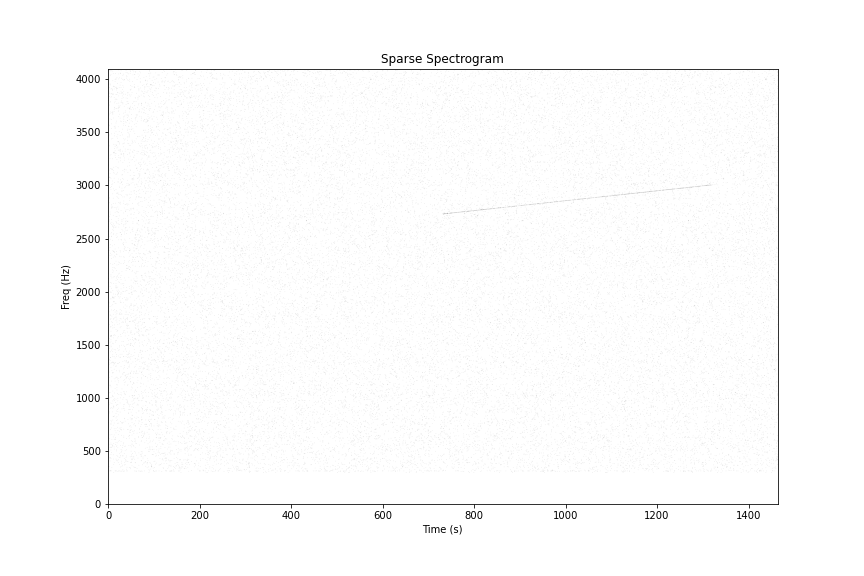

In [14]:
%matplotlib widget

cut_condition = np.array((spec_array > spec_array.mean(axis=0)*5).T , dtype = float)

fig, ax = plt.subplots(figsize=(12,8))

ax.imshow(1-cut_condition,origin='lower', aspect='auto', interpolation=None, cmap = "gray")

ax.set_title("Sparse Spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Freq (Hz)")
plt.show()

In [173]:
#### Start the stopwatch / counter 
t1_start = process_time() 
   
# spec_path = "/home/drew/He6CRES/he6-cres-daq-intuition/config_for_daq/config_example/test_17:47:51_0.spec"
label_path = daq.label_file_paths[0]
print(label_path)
label_array = daq.spec_to_array(label_path, slices = -1)
# Stop the stopwatch / counter
t1_stop = process_time()
   
print(f"Elapsed time: {t1_stop- t1_start:.10f} s" ) 
print(label_array.shape)
np.unique(label_array)

/home/drew/He6CRES/cres_deep_learning/config_files/config_example_0/label_files/test_label_0.spec
(1464, 4096)
Elapsed time: 0.0046464620 s
(1464, 4096)


array([0, 1, 2], dtype=uint8)

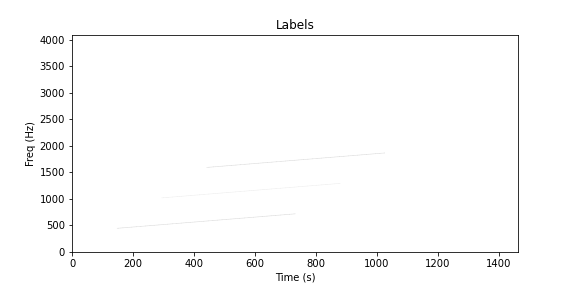

In [174]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,4))

ax.imshow(2 - label_array.T,origin='lower', aspect='auto', interpolation=None, cmap = "gray")

ax.set_title("Labels")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Freq (Hz)")
plt.show()